<a href="https://colab.research.google.com/github/aslesani/pgmpy_fork/blob/master/src/default_test/imdb_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
'''Trains an LSTM model on the IMDB sentiment classification task.
The dataset is actually too small for LSTM to be of any advantage
compared to simpler, much faster methods such as TF-IDF + LogReg.
# Notes
- RNNs are tricky. Choice of batch size is important,
choice of loss and optimizer is critical, etc.
Some configurations won't converge.
- LSTM loss decrease patterns during training can be quite different
from what you see with CNNs/MLPs/etc.
'''
from __future__ import print_function

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM, SimpleRNN, GRU
from keras.datasets import imdb
import numpy as np

from read_write import data_preparation_for_sequences_based_deep_models, convert_binary_classes_to_zero_and_one

from sklearn.metrics import f1_score, precision_score , recall_score, accuracy_score


In [2]:
import matplotlib.pyplot as plt

def plot_train_val_graph(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(loss) + 1)
  print('epochs:' , epochs)
  plt.figure()
  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()
  plt.show()


In [3]:
def get_max_len_of_sequences(list_of_sequences):
  lengths = [len(list_of_sequences[i]) for i in range(len(list_of_sequences))]
  return max(lengths) , min(lengths) , lengths

In [4]:
def get_set_of_sensor_events(list_of_sequences):
 
  set_of_sensor_events = set()
  
  for i in range(len(list_of_sequences)):
      set_of_sensor_events = set_of_sensor_events.union(set(list_of_sequences[i]))
  
  return set_of_sensor_events, len(set_of_sensor_events)
  

In [5]:
#!git clone https://github.com/aslesani/pgmpy_fork.git
#ls
#!git clone https://github.com/aslesani/created_dataset.git
#!rm -r pgmpy_fork  
#cd pgmpy_fork/src/default_test
#cd ..

In [19]:
from keras import backend as K

def mcor(y_true, y_pred):
    #matthews_correlation
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos
 
 
    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos
 
 
    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)
 
 
    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)
 
 
    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
 
 
    return numerator / (denominator + K.epsilon())


def precision(y_true, y_pred):
    """Precision metric.

    Only computes a batch-wise average of precision.

    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def f1_skl(y_true, y_pred):
    f1_score_micro = f1_score(y_true, y_pred, average='micro') 
    return f1_score_micro



In [23]:
y_true = np.array([0, 1, 2, 0, 1, 2])
y_pred = np.array([0, 2, 1, 0, 0, 1])
#print(f1(y_true,y_pred))
print(f1_skl(y_true,y_pred))

0.3333333333333333


In [7]:
#!pip install tabulate 

In [7]:
from tabulate import tabulate

#print(tabulate([['Alice', 24], ['Bob', 19]], headers=['algorithm', 'acc']))

def print_list_of_lists(data , headers):
    print(tabulate(data, headers=headers))



In [7]:
def test_print_list_of_lists():
    data = [['Alice', 24], ['Bob', 19]]
    headers=['algorithm', 'acc']
    print_list_of_lists(data , headers)


In [8]:
test_print_list_of_lists()

algorithm      acc
-----------  -----
Alice           24
Bob             19


In [9]:
def imdb_lstm_data_preparation(max_features = 20000, maxlen = 80):
  #max_features = 20000#number_of_events
  # cut texts after this number of words (among top max_features most common words)
  #maxlen = 10#max_seq_len

  print('Loading data...')
  (x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
  print(len(x_train), 'train sequences')
  print(len(x_test), 'test sequences')

  #print('before apply pad_sequence, x_train[0]:' , x_train[0])

  print('Pad sequences (samples x time)')
  x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
  x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
  print('x_train shape:', x_train.shape)
  print('x_test shape:', x_test.shape)
  
  return x_train, x_test, y_train, y_test, max_features, maxlen

In [12]:
#! cd pgmpy_fork/src/default_test
#!ls
#!git clone https://github.com/pgmpy/pgmpy 
#cd ..
#!ls
#!cd pgmpy/
#pip install -r requirements.txt
#!python setup.py install


In [8]:
def make_lstm_without_embedding(x_train, y_train,x_test, y_test, max_features,embedding_vector_dim = 64, batch_size = 32, epochs = 5, 
                                   loss = 'binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'], plot_train_val_graph = False):
  
  #batch_size = 32

  print('Build model...')
  model = Sequential()
  #model.add(Embedding(max_features+1, embedding_vector_dim))
  #model.add(SimpleRNN(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
  #model.add(SimpleRNN(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
  model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
  model.add(Dense(1, activation='sigmoid'))

  model.summary()

  # try using different optimizers and different optimizer configs
  model.compile(loss= loss,
                optimizer=optimizer,
                metrics= metrics)#, mcor,recall, f1])

  print('Train...')
  history = model.fit(x_train, y_train,
            batch_size=batch_size,
            epochs=epochs,
            validation_data=(x_test, y_test))
  score, acc = model.evaluate(x_test, y_test,
                              batch_size=batch_size)
  print('Test score:', score)# i think score is loss value
  print('Test accuracy:', acc)
 
  if plot_train_val_graph:
      plot_train_val_graph(history)
      
  return score, acc, history, len(x_train), len(x_test)

In [33]:
def create_model_and_apply_on_data(x_train, y_train,x_test, y_test, max_features,
                                   embedding_vector_dim = 64, batch_size = 32, epochs = 3, 
                                   loss = 'binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'], 
                                   plot_trainvalgraph = True,
                                   number_of_lstm_layers = 1,
                                   ID_of_layer_to_repeat = 0):
  '''
  Parameters:
  ===============
  number_of_lstm_layers (default value = 1)
      indicate the number of layers in stack of layers
  
  ID_of_layer_to_repeat (default value = 0)
     0: LSTM
     1:RNN
     2: GRU
  
  '''
  #batch_size = 32

  print('Build model...')
  model = Sequential()
  model.add(Embedding(max_features+1, embedding_vector_dim))
  #model.add(SimpleRNN(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
  #model.add(SimpleRNN(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
  
  layer_names = [LSTM, SimpleRNN, GRU]
  if number_of_lstm_layers > 1:
        for l in range(number_of_lstm_layers-1):
            model.add(layer_names[ID_of_layer_to_repeat](64, dropout=0.2, recurrent_dropout=0.2, return_sequences = True))
  model.add(layer_names[ID_of_layer_to_repeat](64, dropout=0.2, recurrent_dropout=0.2))
        
  model.add(Dense(1, activation='sigmoid'))

  model.summary()

  # try using different optimizers and different optimizer configs
  model.compile(loss= loss,
                optimizer=optimizer,
                metrics= [f1])#metrics, mcor,recall, f1])

  print('Train...')
  history = model.fit(x_train, y_train,
            batch_size=batch_size,
            epochs=epochs,
            validation_data=(x_test, y_test))
  score, acc = model.evaluate(x_test, y_test,
                              batch_size=batch_size)
  #print('Test score:', score)# i think score is loss value
  #print('Test accuracy:', acc)
 
  #print(model.layers[0].output)
  if plot_trainvalgraph:
      plot_train_val_graph(history)
      
  return score, acc, history, len(x_train), len(x_test)

In [31]:
def select_hyperparameters(address_to_read, ID_of_layer_to_repeat, hasActivitycol):
    #address_to_read= r"E:/pgmpy/Seq of sensor events_based on activities/based_on_activities.csv"
    #address_to_read = r"E:\pgmpy\Seq of sensor events_no overlap_based on different deltas\delta_{}min.csv"
    #address_to_read = r"E:\pgmpy\Seq of sensor events_based_on_activity_and_no_overlap_delta\delta_{}min.csv"
    
    for layers in range(2,5):
        print("number_of_lstm_layers:" , layers)

        results = []
        for delta in [15]:#list(range(1,10)):# + [30,45,60,75,90,100]:#, 120,150, 180,200,240,300,400,500,600,700,800,900,1000]: #:
            print("delta:" , delta)
            x_train, x_test, y_train, y_test, max_features, maxlen = data_preparation_for_sequences_based_deep_models(address_to_read = address_to_read.format(delta),
                                                                                                                  number_of_words = 122, 
                                                                                                                  max_seq_len = 20,
                                                                                                                  hasActivitycol= hasActivitycol)
            test_score, test_acc, history, num_of_train_samples, num_of_test_sample = create_model_and_apply_on_data(x_train =x_train, 
                                                                                                y_train = y_train,
                                                                                                x_test = x_test, 
                                                                                                y_test = y_test, 
                                                                                                max_features = max_features,
                                                                                                number_of_lstm_layers = layers,
                                                                                                ID_of_layer_to_repeat = ID_of_layer_to_repeat )
            results.append([delta, 
                        num_of_train_samples, 
                        num_of_test_sample, 
                        history.history['loss'][-1], 
                        history.history['f1'][-1] ,
                        test_score, 
                        test_acc])#, history.history
        #print(history.history)
        print_list_of_lists(results, ['delta(min)' ,
                                  '#train', 
                                  '#test', 
                                  'train loss(last)', 
                                  'train_f1(last)', 
                                  'val loss ', 
                                  'val f1', ])#'history'
        print("results:", results)
        #print("results[:][-1]:", results[:][-1])
        #best_val_acc_index = np.argmax(results[:][-1])
        #print("****************************************")
        #print("best vlidation acc delta:" , results[best_val_acc_index][0])
    
    return results
    
    

E:\pgmpy\Twor2009\Seq of sensor events_no overlap_based on different deltas\delta_{}min.csv
ID_of_layer_to_repeat: 0
number_of_lstm_layers: 2
delta: 15
Pad sequences (samples x time)
x_train shape: (2134, 20)
x_test shape: (533, 20)
Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_23 (Embedding)     (None, None, 64)          7872      
_________________________________________________________________
lstm_51 (LSTM)               (None, None, 64)          33024     
_________________________________________________________________
lstm_52 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 65        
Total params: 73,985
Trainable params: 73,985
Non-trainable params: 0
_________________________________________________________________
Train...
Train on 2134

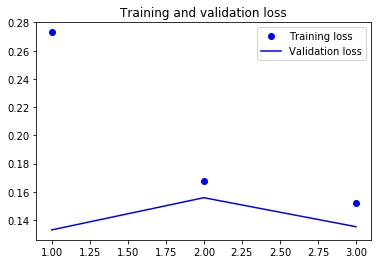

  delta(min)    #train    #test    train loss(last)    train_f1(last)    val loss     val f1
------------  --------  -------  ------------------  ----------------  -----------  --------
          15      2134      533            0.152141          0.931024     0.135208  0.967304
results: [[15, 2134, 533, 0.15214142214503373, 0.9310238169193714, 0.13520763421514836, 0.9673041832156297]]
number_of_lstm_layers: 3
delta: 15
Pad sequences (samples x time)
x_train shape: (2134, 20)
x_test shape: (533, 20)
Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_24 (Embedding)     (None, None, 64)          7872      
_________________________________________________________________
lstm_53 (LSTM)               (None, None, 64)          33024     
_________________________________________________________________
lstm_54 (LSTM)               (None, None, 64)          33024     
___________________

KeyboardInterrupt: 

In [34]:
#address_to_read, hasActivitycol= r"E:/pgmpy\Twor2009\Seq of sensor events_based on activities\based_on_activities.csv", True
address_to_read, hasActivitycol = r"E:\pgmpy\Twor2009\Seq of sensor events_no overlap_based on different deltas\delta_{}min.csv", False
#address_to_read, hasActivitycol = r"E:\pgmpy\Twor2009\Seq of sensor events_based_on_activity_and_no_overlap_delta\delta_{}min.csv", True
print(address_to_read)
ID_of_layer_to_repeat = 0
print("ID_of_layer_to_repeat:" , ID_of_layer_to_repeat)
results = select_hyperparameters(address_to_read = address_to_read , 
                                 ID_of_layer_to_repeat = ID_of_layer_to_repeat, 
                                 hasActivitycol = hasActivitycol)

In [19]:
print(results[:][-1])
print(np.argmax(results[:][-1]))

TypeError: 'NoneType' object is not subscriptable

In [16]:
address_to_read= r"E:/pgmpy/Test2/Seq of sensor events_based on activities/based_on_activities.csv"

x_train, x_test, y_train, y_test, max_features, maxlen = data_preparation_for_sequences_based_deep_models(address_to_read,
                                                                                                         number_of_words = 122, 
                                                                                                        max_seq_len = 20,
                                                                                                         hasActivitycol = True)
ID_of_layer_to_repeat = 0
test_score, test_acc, history, num_of_train_samples, num_of_test_sample = create_model_and_apply_on_data(x_train, 
                                                                                                        y_train,
                                                                                                        x_test, 
                                                                                                        y_test, 
                                                                                                        max_features,
                                                                                                        ID_of_layer_to_repeat = ID_of_layer_to_repeat)
print("test_score:",test_score)
print("test_acc:" , test_acc)
print("history:" , history.history)
print("num_of_train_samples:" , num_of_train_samples)
print("num_of_test_sample:" , num_of_test_sample)


Pad sequences (samples x time)
x_train shape: (3, 20)
x_test shape: (0, 20)
Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 64)          7872      
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 40,961
Trainable params: 40,961
Non-trainable params: 0
_________________________________________________________________
Train...


IndexError: list index out of range

In [16]:
x_train, x_test, y_train, y_test, max_features, maxlen = imdb_lstm_data_preparation(maxlen=10)
#my_x_train, my_x_test, my_y_train, my_y_test, my_max_features, my_maxlen = data_preparation_for_sequences_based_deep_models(address_to_read)
#x_train, x_test, y_train, y_test, max_features, maxlen = data_preparation_for_sequences_based_deep_models(address_to_read)#imdb_lstm_data_preparation(maxlen=10)
create_model_and_apply_on_data(x_train, y_train,x_test, y_test, max_features,embedding_vector_dim = maxlen)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 10)
x_test shape: (25000, 10)
Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 10)          200010    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                19200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 219,275
Trainable params: 219,275
Non-trainable params: 0
_________________________________________________________________
Train...
Train on 25000 samples, validate on 25000 samples
Epoch 1/5
25000/25000 [==============================] - 16s 653us/step - loss: 0.6015 - acc: 0.6613 - val_loss: 0.5451 - val_acc: 0.7164
Epoch 2/5
25000/25000 [======================

(0.52888289176940917,
 0.72951999999999995,
 25000,
 25000)

In [ ]:
embeddings = model.layers[0].get_weights()[0]
print(embeddings)

In [ ]:
# `word_to_index` is a mapping (i.e. dict) from words to their index, e.g. `love`: 69
words_embeddings = {w:embeddings[idx] for w, idx in word_to_index.items()}

# now you can use it like this for example
print(words_embeddings['love'])  # possible output: [0.21, 0.56, ..., 0.65, 0.10]


In [ ]:
print(type(score) , type(acc))